### 総合演習データパイプライン

* 入力：CSVファイル ("C:\Users\Admin\ILP\Python-AI\raw_data.csv")
* FeatherL:C:\Users\81803\ILP\Python-AI\merged_data.feather
* 出力：

In [1]:
#必要なライブラリ
import pandas as pd
import numpy as np
import pyarrow.feather as feather
from sklearn.preprocessing import LabelEncoder

In [137]:
df = pd.read_csv('newrawdata.csv',encoding='utf-8')
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

df

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3434063758.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


,日付,曜日,予約件数,予約人数,来客数,総杯数,売上合計(円),ペールエール(本),ペールエール(円),ラガー(本),ラガー(円),IPA(本),IPA(円),ホワイトビール(本),ホワイトビール(円),黒ビール(本),黒ビール(円),フルーツビール(本),フルーツビール(円)
0,2024-04-01,月,NaN,NaN,16,25,25300,6,6000,5,4000,5,4500,4,3600,6,7200,0,0
1,2024-04-02,火,NaN,NaN,19,25,24600,6,6000,4,3200,5,4500,3,2700,6,7200,1,1000
2,2024-04-03,水,NaN,NaN,11,19,18500,5,5000,4,3200,3,2700,2,1800,4,4800,1,1000
3,2024-04-04,木,NaN,NaN,6,10,9500,2,2000,2,1600,2,1800,1,900,1,1200,2,2000
4,2024-04-05,金,NaN,NaN,10,18,17100,3,3000,5,4000,3,2700,2,1800,3,3600,2,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2025-03-27,木,NaN,NaN,10,14,13400,2,2000,3,2400,2,1800,2,1800,2,2400,3,3000
310,2025-03-28,金,NaN,NaN,14,28,26900,6,6000,7,5600,3,2700,4,3600,5,6000,3,3000
311,2025-03-29,土,NaN,NaN,6,8,7600,2,2000,2,1600,1,900,1,900,1,1200,1,1000
312,2025-03-31,月,NaN,NaN,9,15,14800,4,4000,2,1600,2,1800,2,1800,3,3600,2,2000


In [14]:
import pandas as pd

df = pd.read_csv('./data/raw_data.csv', encoding='utf-8')

# 1. 过滤掉 '日付'、空行或其它异常值
mask = df['日付'].astype(str).str.match(r'^\d{4}/\d{1,2}/\d{1,2}$')
df = df.loc[mask].copy()

# 2. 解析为 datetime
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

# 3. 验证
print(df['日付'].head())
print(df.info())


0   2024-04-01
1   2024-04-02
2   2024-04-03
3   2024-04-04
4   2024-04-05
Name: 日付, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 325
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   日付          315 non-null    datetime64[ns]
 1   予約件数        28 non-null     object        
 2   予約人数        47 non-null     object        
 3   来客数         314 non-null    object        
 4   総杯数         314 non-null    object        
 5   売上合計(円)     313 non-null    object        
 6   ペールエール(本)   310 non-null    object        
 7   ペールエール(円)   310 non-null    object        
 8   ラガー(本)      307 non-null    object        
 9   ラガー(円)      307 non-null    object        
 10  IPA(本)      286 non-null    object        
 11  IPA(円)      285 non-null    object        
 12  ホワイトビール(本)  259 non-null    object        
 13  ホワイトビール(円)  257 non-null    object        
 14  黒ビール(本)     233 non-

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2808381903.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


In [15]:
# 定义包含各品类销售额的列名
sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 去掉千分位逗号并转成数值
for col in sales_cols + ['売上合計(円)']:
    df[col] = (
        df[col]
        .fillna('0')            # 将 NaN 当作 "0" 处理
        .astype(str)
        .str.replace(',', '')   # 移除逗号
        .astype(float)          # 转为 float
    )

# 重新计算総売上額
df['総売上額'] = df[sales_cols].sum(axis=1)

# 查看原始合计和重新计算的对比
print(df[['日付', '売上合計(円)', '総売上額']].head())


          日付  売上合計(円)     総売上額
0 2024-04-01  31800.0  31800.0
1 2024-04-02  23300.0  23300.0
2 2024-04-03  33600.0  33600.0
3 2024-04-04  24600.0  24600.0
4 2024-04-05  56500.0  56500.0


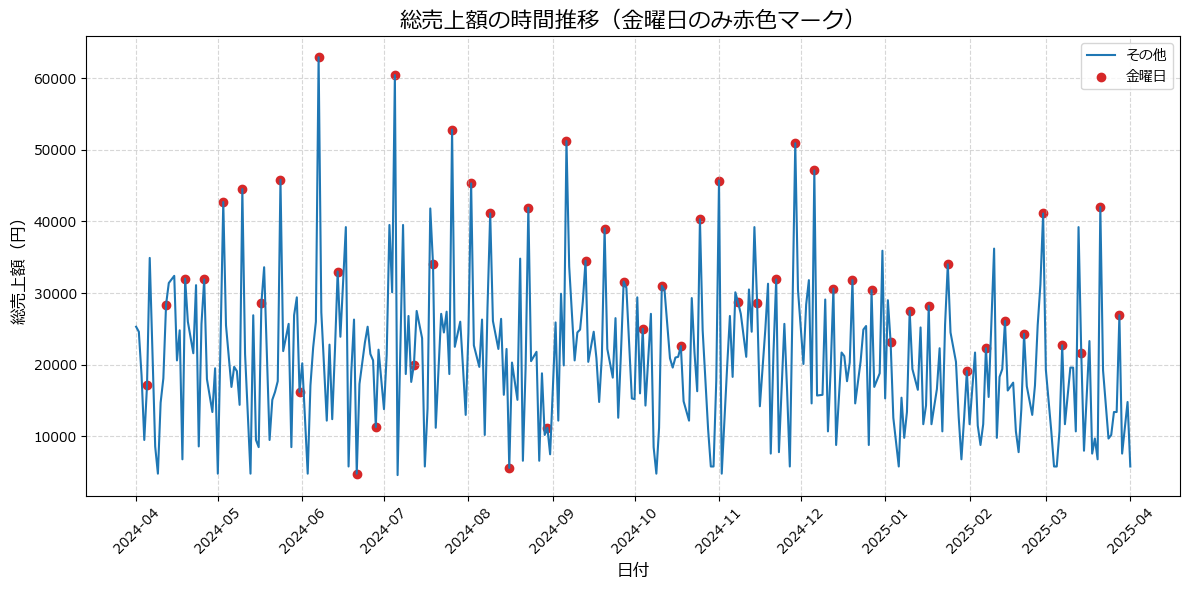

In [132]:
# ...existing code...
dates = df['日付']
sales = df['売上合計(円)']
friday_mask = dates.dt.weekday == 4  # 金曜日のみ

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, sales, linestyle='-', label='その他', color='tab:blue')
ax.scatter(dates[friday_mask], sales[friday_mask],
           color='tab:red', marker='o', label='金曜日')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.legend()
ax.set_title('総売上額の時間推移（金曜日のみ赤色マーク）', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('総売上額（円）', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
# ...existing code...
# 读取数据
import pandas as pd

# 假设df和weatherdf都已读取
# df = pd.read_feather('xxx.feather')
# weatherdf = pd.read_feather('yyy.feather')

# 找出weatherdf中除'日付'外的所有列
weather_cols = [col for col in weatherdf.columns if col != '日付']

# 先把df中这些列删掉（如果有的话）
df = df.drop(columns=[col for col in weather_cols if col in df.columns], errors='ignore')

# 合并，weatherdf中的同名列会覆盖df
mergeddf = pd.merge(df, weatherdf, on='日付', how='left')

# 保存或继续使用mergeddf
# mergeddf.to_feather('mergeddf.feather')
# ...existing code...

In [139]:
mergeddf = pd.merge(df, weatherdf, on='日付', how='left')
mergeddf

,日付,曜日,予約件数,予約人数,来客数,総杯数,売上合計(円),ペールエール(本),ペールエール(円)_x,ラガー(本),...,10分間降水量の最大(mm),天気概況(昼：06時～18時),天気概況(夜：18時～翌日06時),ペールエール(円)_y,ラガー(円)_y,IPA(円)_y,ホワイトビール(円)_y,黒ビール(円)_y,フルーツビール(円)_y,総売上額
0,2024-04-01,月,NaN,NaN,16,25,25300,6,6000,5,...,1.5,曇時々雨一時晴,快晴,10000.0,8000.0,4500.0,4500.0,4800.0,0.0,31800.0
1,2024-04-02,火,NaN,NaN,19,25,24600,6,6000,4,...,0.0,晴後薄曇,曇,8000.0,5600.0,2700.0,3600.0,2400.0,1000.0,23300.0
2,2024-04-03,水,NaN,NaN,11,19,18500,5,5000,4,...,1.5,雨時々曇,雨時々曇,7000.0,6400.0,5400.0,5400.0,2400.0,7000.0,33600.0
3,2024-04-04,木,NaN,NaN,6,10,9500,2,2000,2,...,1.5,曇一時雨,曇後一時雨,6000.0,7200.0,3600.0,3600.0,1200.0,3000.0,24600.0
4,2024-04-05,金,NaN,NaN,10,18,17100,3,3000,5,...,0.5,曇時々雨,曇時々雨,15000.0,14400.0,8100.0,7200.0,4800.0,7000.0,56500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,2025-03-27,木,NaN,NaN,10,14,13400,2,2000,3,...,0.0,薄曇一時晴,曇,1000.0,800.0,900.0,0.0,0.0,1000.0,3700.0
314,2025-03-28,金,NaN,NaN,14,28,26900,6,6000,7,...,1.0,薄曇時々晴一時雨,雨時々曇一時晴,25000.0,16000.0,10800.0,8100.0,6000.0,3000.0,68900.0
315,2025-03-29,土,NaN,NaN,6,8,7600,2,2000,2,...,1.0,雨,曇時々雨,1000.0,800.0,0.0,0.0,0.0,0.0,1800.0
316,2025-03-31,月,NaN,NaN,9,15,14800,4,4000,2,...,0.0,曇時々雨,雨一時曇,5000.0,5600.0,3600.0,1800.0,2400.0,1000.0,19400.0


In [188]:
mergeddf.to_json('mergeddf.json', orient='records', force_ascii=False, indent=4)
mergeddf.to_feather('mergeddf.feather')

In [186]:

mergeddf.isnull().sum()

日付                   0
曜日                   0
来客数                  0
総杯数                  0
売上合計(円)              0
ペールエール(本)            0
ペールエール(円)_x          0
ラガー(本)               0
ラガー(円)_x             0
IPA(本)               0
IPA(円)_x             0
ホワイトビール(本)           0
ホワイトビール(円)_x         0
黒ビール(本)              0
黒ビール(円)_x            0
フルーツビール(本)           0
フルーツビール(円)_x         0
平均気温(℃)              1
日照時間(時間)             1
降雪量合計(cm)            1
平均湿度(％)              1
最高気温(℃)              1
最低気温(℃)              1
10分間降水量の最大(mm)       1
天気概況(昼：06時～18時)      1
天気概況(夜：18時～翌日06時)    1
dtype: int64

In [182]:
# 1. 读取原始 weather 数据
weather_raw = pd.read_json('./data/weather_data.json', encoding='utf-8',lines=True)
weather_raw['日付'] = pd.to_datetime(weather_raw['年月日'])
weather_raw.drop(columns=['年月日'], inplace=True, errors='ignore')

# 2. 只保留气象相关列（假设这些列名和mergeddf一致）
weather_cols = [
    '日付', '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)',
    '最高気温(℃)', '最低気温(℃)', '10分間降水量の最大(mm)',
    '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)'
]
weather_raw = weather_raw[weather_cols]
weather_raw

,日付,平均気温(℃),日照時間(時間),降雪量合計(cm),平均湿度(％),最高気温(℃),最低気温(℃),10分間降水量の最大(mm),天気概況(昼：06時～18時),天気概況(夜：18時～翌日06時)
0,2024-04-01,14.6,3.8,0,73,19.7,11.8,1.5,曇時々雨一時晴,快晴
1,2024-04-02,14.2,10.6,0,50,20.6,8.4,0.0,晴後薄曇,曇
2,2024-04-03,13.9,0.0,0,83,16.6,12.3,1.5,雨時々曇,雨時々曇
3,2024-04-04,15.4,0.1,0,79,19.9,11.3,1.5,曇一時雨,曇後一時雨
4,2024-04-05,11.4,0.0,0,71,15.1,9.0,0.5,曇時々雨,曇時々雨
...,...,...,...,...,...,...,...,...,...,...
360,2025-03-27,17.9,5.6,0,69,22.4,12.2,0.0,薄曇一時晴,曇
361,2025-03-28,19.9,4.1,0,79,25.7,14.1,1.0,薄曇時々晴一時雨,雨時々曇一時晴
362,2025-03-29,7.6,0.0,0,90,14.3,4.3,1.0,雨,曇時々雨
363,2025-03-30,9.4,6.1,0,63,15.6,5.1,0.5,薄曇時々晴,曇時々雨


In [185]:
# 3. 用日付合并，优先用mergeddf已有数据，NaN用weather_raw补
mergeddf = pd.merge(
    mergeddf, weather_raw, on='日付', how='left', suffixes=('', '_raw')
)

for col in weather_cols:
    if col == '日付':
        continue
    # 如果原列是NaN，则用_raw列补
    mergeddf[col] = mergeddf[col].combine_first(mergeddf[f"{col}_raw"])
    mergeddf.drop(columns=[f"{col}_raw"], inplace=True)

# 4. 检查是否还有NaN
print(mergeddf[weather_cols].isnull())

        日付  平均気温(℃)  日照時間(時間)  降雪量合計(cm)  平均湿度(％)  最高気温(℃)  最低気温(℃)  \
0    False    False     False      False    False    False    False   
1    False    False     False      False    False    False    False   
2    False    False     False      False    False    False    False   
3    False    False     False      False    False    False    False   
4    False    False     False      False    False    False    False   
..     ...      ...       ...        ...      ...      ...      ...   
313  False    False     False      False    False    False    False   
314  False    False     False      False    False    False    False   
315  False    False     False      False    False    False    False   
316  False    False     False      False    False    False    False   
317  False     True      True       True     True     True     True   

     10分間降水量の最大(mm)  天気概況(昼：06時～18時)  天気概況(夜：18時～翌日06時)  
0             False            False              False  
1             False            

In [136]:
weatherdf = feather.read_feather('merged_data.feather')
weatherdf

,日付,平均気温(℃),日照時間(時間),降雪量合計(cm),平均湿度(％),最高気温(℃),最低気温(℃),10分間降水量の最大(mm),天気概況(昼：06時～18時),天気概況(夜：18時～翌日06時),ペールエール(円),ラガー(円),IPA(円),ホワイトビール(円),黒ビール(円),フルーツビール(円),総売上額
0,2024-04-01,14.6,3.8,0,73,19.7,11.8,1.5,曇時々雨一時晴,快晴,10000.0,8000.0,4500.0,4500.0,4800.0,0.0,31800.0
1,2024-04-02,14.2,10.6,0,50,20.6,8.4,0.0,晴後薄曇,曇,8000.0,5600.0,2700.0,3600.0,2400.0,1000.0,23300.0
2,2024-04-03,13.9,0.0,0,83,16.6,12.3,1.5,雨時々曇,雨時々曇,7000.0,6400.0,5400.0,5400.0,2400.0,7000.0,33600.0
3,2024-04-04,15.4,0.1,0,79,19.9,11.3,1.5,曇一時雨,曇後一時雨,6000.0,7200.0,3600.0,3600.0,1200.0,3000.0,24600.0
4,2024-04-05,11.4,0.0,0,71,15.1,9.0,0.5,曇時々雨,曇時々雨,15000.0,14400.0,8100.0,7200.0,4800.0,7000.0,56500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2025-03-26,20.4,10.2,0,45,25.9,14.9,0.0,晴,薄曇時々晴,6000.0,5600.0,2700.0,1800.0,2400.0,2000.0,20500.0
305,2025-03-27,17.9,5.6,0,69,22.4,12.2,0.0,薄曇一時晴,曇,1000.0,800.0,900.0,0.0,0.0,1000.0,3700.0
306,2025-03-28,19.9,4.1,0,79,25.7,14.1,1.0,薄曇時々晴一時雨,雨時々曇一時晴,25000.0,16000.0,10800.0,8100.0,6000.0,3000.0,68900.0
307,2025-03-29,7.6,0.0,0,90,14.3,4.3,1.0,雨,曇時々雨,1000.0,800.0,0.0,0.0,0.0,0.0,1800.0


In [73]:
df.to_json('./data/merged_data.json', orient='records', force_ascii=False, lines=True)

In [36]:
# ...existing code...
# 1. 不要な列を削除
drop_cols = [
    '来客数', '総杯数', 'ペールエール(本)', 'ラガー(本)', 'ラガー(円)', 'IPA(本)', 'IPA(円)',
    'ホワイトビール(本)', 'ホワイトビール(円)', '黒ビール(本)', 'フルーツビール(本)'
]
df_cleaned = df.drop(columns=drop_cols, errors='ignore')

# 2. df_cleanedとdf_selectedを日付でマージ
merged_df = pd.merge(df_cleaned, df_selected, on='日付', suffixes=('_orig', '_selected'))

# 必要なら保存
merged_df.drop(columns=['一致', '品种合計'], inplace=True, errors='ignore')
merged_df.head()
# 保存マージされたデータ
merged_df.to_feather('merged_data.feather')
# ...existing code...

In [38]:
df = feather.read_feather('merged_data.feather')
df.columns.unique()

Index(['日付', '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)',
       '最低気温(℃)', '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)',
       'ペールエール(円)', 'ラガー(円)', 'IPA(円)', 'ホワイトビール(円)', '黒ビール(円)', 'フルーツビール(円)',
       '総売上額'],
      dtype='object')

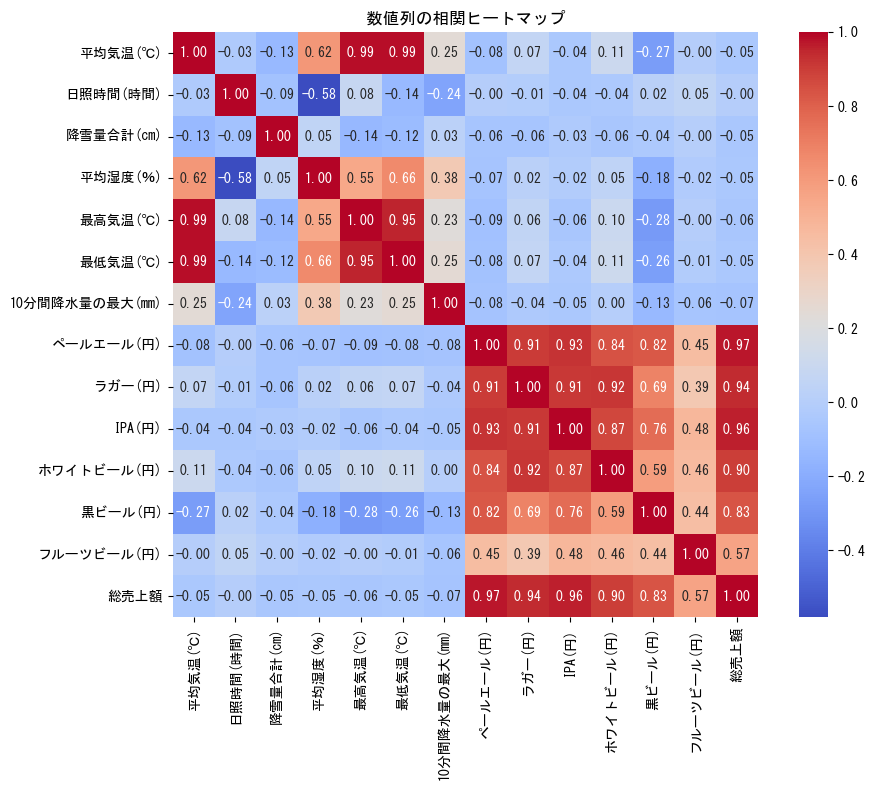

In [40]:
# ...existing code...
import seaborn as sns
import matplotlib.pyplot as plt

# 数値列のみ抽出
corr = merged_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('数値列の相関ヒートマップ')
plt.tight_layout()
plt.show()
# ...existing code...

                      ペールエール(円)        ラガー(円)       IPA(円)   ホワイトビール(円)  \
天気概況(夜：18時～翌日06時)                                                         
大雨                  7333.333333   5066.666667  3000.000000  2700.000000   
大雨時々曇、雷を伴う          1000.000000   1200.000000   450.000000   450.000000   
快晴                  6413.043478   4208.695652  2817.391304  2073.913043   
晴                   8482.758621   6289.655172  3786.206897  3289.655172   
晴一時曇                6357.142857   4914.285714  3407.142857  2250.000000   
晴一時薄曇               7666.666667   5333.333333  3900.000000  2400.000000   
晴後一時曇               7833.333333   5266.666667  3225.000000  2550.000000   
晴後一時薄曇              9555.555556   7644.444444  4400.000000  3900.000000   
晴後曇                 4833.333333   4133.333333  1950.000000  2250.000000   
晴後曇一時雨              7000.000000   5600.000000  2700.000000  2700.000000   
晴後曇時々雨、あられを伴う       1000.000000    800.000000   900.000000     0.000000   
晴後薄曇                2000.

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\4205298099.py:16: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\4205298099.py:16: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\4205298099.py:16: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\I

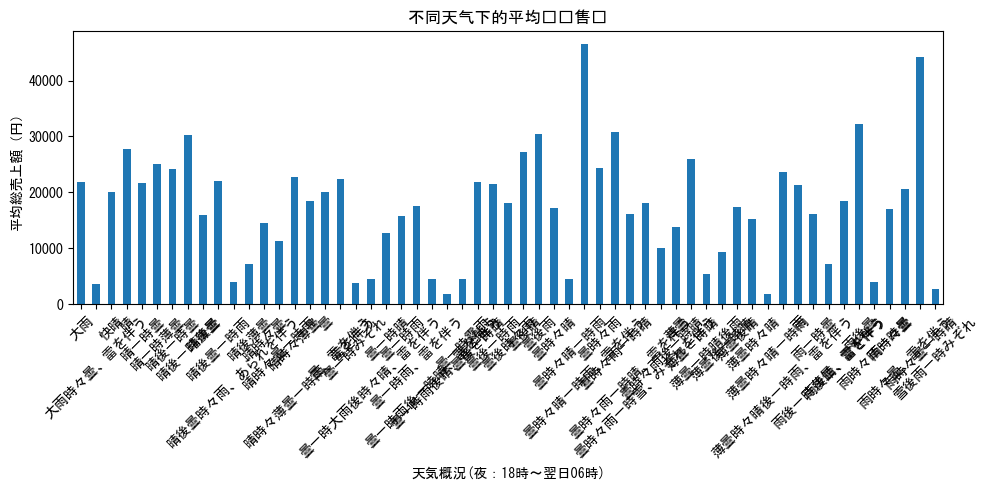

In [48]:
# ...existing code...
# 按白天天气分组，计算各类啤酒和总销售额的均值
grouped = merged_df.groupby('天気概況(夜：18時～翌日06時)')[
    ['ペールエール(円)', 'ラガー(円)', 'IPA(円)', 'ホワイトビール(円)', '黒ビール(円)', 'フルーツビール(円)', '総売上額']
].mean()

print(grouped)

# 可视化
import matplotlib.pyplot as plt

grouped['総売上額'].plot(kind='bar', figsize=(10,5))
plt.ylabel('平均総売上額（円）')
plt.title('不同天气下的平均总销售额')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

In [80]:
df['weekday'] = df['日付'].dt.weekday       # 0=周一 … 6=周日
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month'] = df['日付'].dt.month
df['quarter'] = df['日付'].dt.quarter
df

,日付,平均気温(℃),日照時間(時間),降雪量合計(cm),平均湿度(％),最高気温(℃),最低気温(℃),10分間降水量の最大(mm),天気概況(昼：06時～18時),天気概況(夜：18時～翌日06時),...,ラガー(円),IPA(円),ホワイトビール(円),黒ビール(円),フルーツビール(円),総売上額,weekday,is_weekend,month,quarter
0,2024-04-01,14.6,3.8,0,73,19.7,11.8,1.5,曇時々雨一時晴,快晴,...,8000.0,4500.0,4500.0,4800.0,0.0,31800.0,0,0,4,2
1,2024-04-02,14.2,10.6,0,50,20.6,8.4,0.0,晴後薄曇,曇,...,5600.0,2700.0,3600.0,2400.0,1000.0,23300.0,1,0,4,2
2,2024-04-03,13.9,0.0,0,83,16.6,12.3,1.5,雨時々曇,雨時々曇,...,6400.0,5400.0,5400.0,2400.0,7000.0,33600.0,2,0,4,2
3,2024-04-04,15.4,0.1,0,79,19.9,11.3,1.5,曇一時雨,曇後一時雨,...,7200.0,3600.0,3600.0,1200.0,3000.0,24600.0,3,0,4,2
4,2024-04-05,11.4,0.0,0,71,15.1,9.0,0.5,曇時々雨,曇時々雨,...,14400.0,8100.0,7200.0,4800.0,7000.0,56500.0,4,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2025-03-26,20.4,10.2,0,45,25.9,14.9,0.0,晴,薄曇時々晴,...,5600.0,2700.0,1800.0,2400.0,2000.0,20500.0,2,0,3,1
305,2025-03-27,17.9,5.6,0,69,22.4,12.2,0.0,薄曇一時晴,曇,...,800.0,900.0,0.0,0.0,1000.0,3700.0,3,0,3,1
306,2025-03-28,19.9,4.1,0,79,25.7,14.1,1.0,薄曇時々晴一時雨,雨時々曇一時晴,...,16000.0,10800.0,8100.0,6000.0,3000.0,68900.0,4,0,3,1
307,2025-03-29,7.6,0.0,0,90,14.3,4.3,1.0,雨,曇時々雨,...,800.0,0.0,0.0,0.0,0.0,1800.0,5,1,3,1


训练集：(284, 8), 测试集：(25, 8)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 8
[LightGBM] [Info] Start training from score 20670.070423
Test R²: -0.198
Test RMSE: 292780723 円


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1947265294.py:86: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1947265294.py:86: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1947265294.py:86: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1947265294.py:86: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1947265294.py:86: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1947265294.py:86: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) 

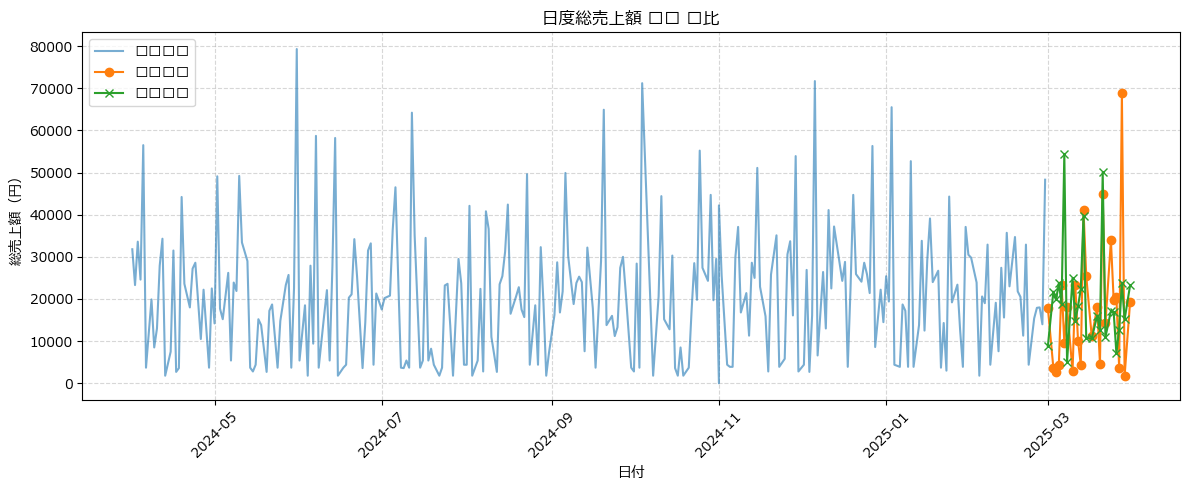

In [92]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 用于加载本地字体

# —— 0. 字体配置（避免日文乱码） ——
# 举例：Windows 下用 Meiryo；macOS/Linux 可换成系统里已有的日文字体路径
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# —— 1. 读取 Feather 文件 ——
# 直接用 pandas 自带的 read_feather，无需额外安装 feather 库
df = pd.read_feather('merged_data.feather')

# —— 2. 清洗“(円)”字段 ——
money_cols = [
    'ペールエール(円)','ラガー(円)','IPA(円)',
    'ホワイトビール(円)','黒ビール(円)','フルーツビール(円)'
]
for c in money_cols:
    df[c] = (
        df[c]
        .fillna('0')
        .astype(str)
        .str.replace(',', '')
        .astype(float)
    )

# 目标：总销售额
df['総売上額'] = df[money_cols].sum(axis=1)

# —— 3. 特征工程（仅天气+时间特征） ——
df['weekday']    = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']      = df['日付'].dt.month
df['dayofyear']  = df['日付'].dt.dayofyear

weather_cols = [
    '平均気温(℃)','最高気温(℃)','最低気温(℃)','10分間降水量の最大(mm)'
]
df[weather_cols] = df[weather_cols].fillna(0)

# —— 4. 划分训练/测试 ——
cut_date = df['日付'].max() - pd.Timedelta(days=30)
train = df[df['日付'] < cut_date]
test  = df[df['日付'] >= cut_date]

feature_cols = weather_cols + ['weekday','is_weekend','month','dayofyear']
X_train, y_train = train[feature_cols], train['総売上額']
X_test,  y_test  = test[feature_cols],  test['総売上額']

print(f"训练集：{X_train.shape}, 测试集：{X_test.shape}")

# —— 5. 训练 LightGBM ———
# 这里统一使用 min_child_samples，移除重复的 min_data_in_leaf 参数
model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=200,
    random_state=42,
    min_child_samples=5,  # 叶子节点上至少 5 个样本
    min_data_in_bin=1,
    max_bin=50
)
model.fit(X_train, y_train)

# —— 6. 评估 ———
y_pred = model.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred):.0f} 円")

# —— 7. 可视化对比 ———
plt.figure(figsize=(12,5))
plt.plot(train['日付'], y_train, label='训练实际', alpha=0.6)
plt.plot(test['日付'],  y_test,  label='测试实际',  marker='o')
plt.plot(test['日付'],  y_pred,  label='测试预测',  marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title('日度総売上額 预测 对比')
plt.xlabel('日付')
plt.ylabel('総売上額（円）')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


训练样本: (283, 10), 测试样本: (25, 10)
Test R²: 0.102
Test RMSE: 219498685 円


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\860400631.py:83: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\860400631.py:83: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\860400631.py:83: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\860400631.py:83: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\860400631.py:83: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\860400631.py:83: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missin

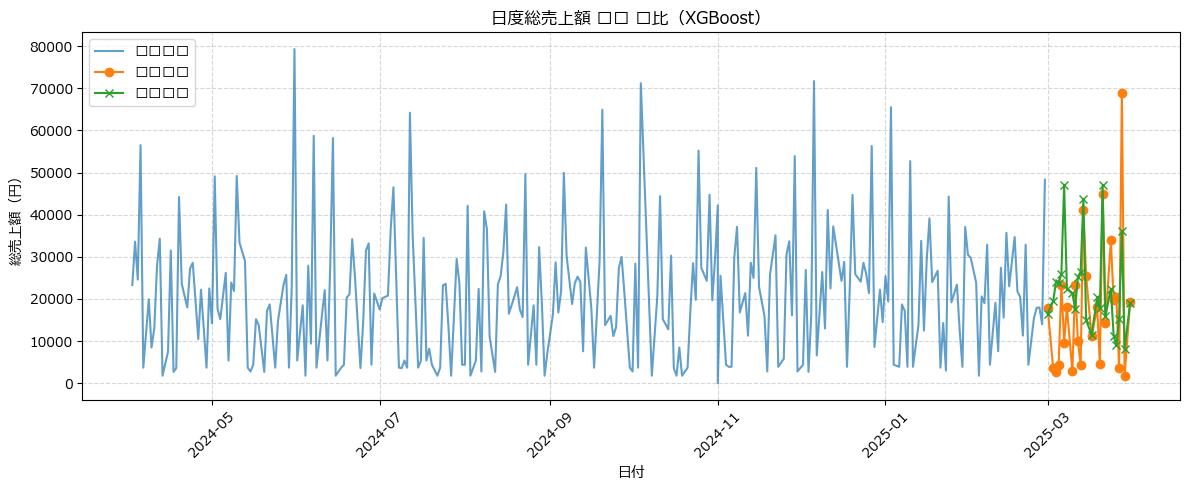

In [95]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# —— 1. 读取并清洗 ——
df = pd.read_feather('merged_data.feather')

# 清洗“(円)”字段
money_cols = [
    'ペールエール(円)','ラガー(円)','IPA(円)',
    'ホワイトビール(円)','黒ビール(円)','フルーツビール(円)'
]
for c in money_cols:
    df[c] = df[c].fillna('0').astype(str).str.replace(',', '').astype(float)
df['総売上額'] = df[money_cols].sum(axis=1)

# —— 2. 特征工程 —— 
df = df.sort_values('日付').reset_index(drop=True)

# 时间特征
df['weekday']    = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']      = df['日付'].dt.month
df['dayofyear']  = df['日付'].dt.dayofyear

# 天气特征
weather_cols = [
    '平均気温(℃)','最高気温(℃)','最低気温(℃)','10分間降水量の最大(mm)'
]
df[weather_cols] = df[weather_cols].fillna(0)

# 构造滞后 & 滚动特征（先 shift 再 rolling，再 drop 同一行的 NaN）
df['lag1']       = df['総売上額'].shift(1)
df['roll7_mean'] = df['総売上額'].shift(1).rolling(7, min_periods=1).mean()

# 丢掉因 shift/rolling 产生的 NaN（第一行 lag1 会是 NaN）
df = df.dropna(subset=['lag1', 'roll7_mean']).reset_index(drop=True)

# —— 3. 划分训练/测试 ——
cut_date = df['日付'].max() - pd.Timedelta(days=30)
train = df[df['日付'] < cut_date]
test  = df[df['日付'] >= cut_date]

feature_cols = weather_cols + [
    'weekday','is_weekend','month','dayofyear',
    'lag1','roll7_mean'
]
X_train, y_train = train[feature_cols], train['総売上額']
X_test,  y_test  = test[feature_cols],  test['総売上額']

print(f"训练样本: {X_train.shape}, 测试样本: {X_test.shape}")

# —— 4. 训练 XGBoost —— 
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# —— 5. 评估 —— 
y_pred = model.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred):.0f} 円")

# —— 6. 可视化对比 —— 
plt.figure(figsize=(12,5))
plt.plot(train['日付'], y_train, label='训练实际', alpha=0.7)
plt.plot(test['日付'],  y_test,  label='测试实际',  marker='o')
plt.plot(test['日付'],  y_pred,  label='测试预测',  marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title('日度総売上額 预测 对比（XGBoost）')
plt.xlabel('日付')
plt.ylabel('総売上額（円）')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


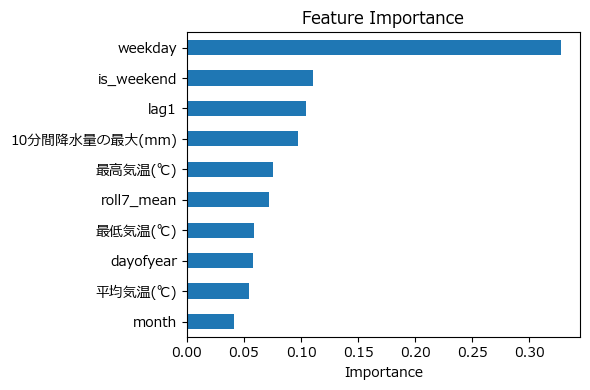

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 model 是刚训练好的 XGBRegressor，feature_cols 是你的特征列表
fi = pd.Series(model.feature_importances_, index=feature_cols)
fi = fi.sort_values(ascending=True)

plt.figure(figsize=(6,4))
fi.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [113]:
# —— 1. 读取 & 清洗 ——
df = pd.read_feather('merged_data.feather')

# 清洗价格字段
money_cols = [
    'ペールエール(円)','ラガー(円)','IPA(円)',
    'ホワイトビール(円)','黒ビール(円)','フルーツビール(円)'
]
for c in money_cols:
    df[c] = df[c].fillna('0').astype(str).str.replace(',', '').astype(float)
df['総売上額'] = df[money_cols].sum(axis=1)

# —— 2. 特征工程 —— 
df = df.sort_values('日付').reset_index(drop=True)
df['weekday']    = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']      = df['日付'].dt.month
df['dayofyear']  = df['日付'].dt.dayofyear

# 天气
weather_cols = [
    '平均気温(℃)','最高気温(℃)','最低気温(℃)','10分間降水量の最大(mm)'
]
df[weather_cols] = df[weather_cols].fillna(0)



# 法定节假日
df['is_holiday'] = df['日付'].apply(lambda d: 1 if jpholiday.is_holiday(d) else 0)

# 滞后与滚动
df['lag1']       = df['総売上額'].shift(1)
df['roll7_mean'] = df['総売上額'].shift(1).rolling(7, min_periods=1).mean()

# 丢掉 NaN
df = df.dropna(subset=['lag1','roll7_mean']).reset_index(drop=True)

Test R²: 0.005
Test RMSE: 243202568 円
实际迭代次数： 1000


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36718 (\N{C

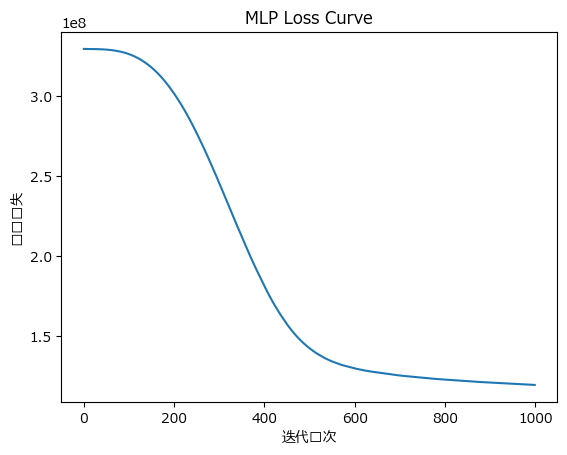

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2813260216.py:89: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2813260216.py:89: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2813260216.py:89: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2813260216.py:89: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2813260216.py:89: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2813260216.py:89: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) 

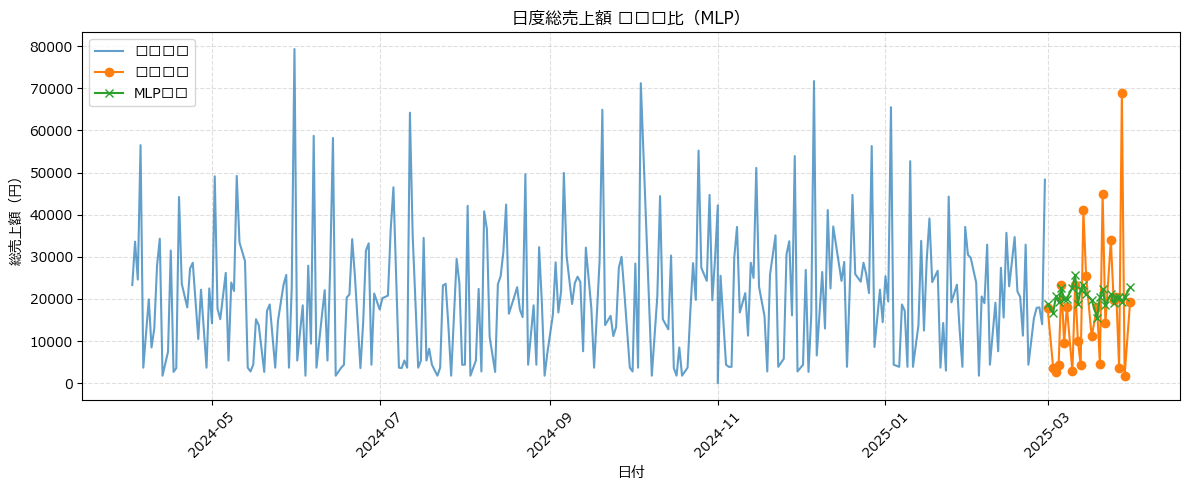

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# —— 1. 读取 & 清洗 —— 
df = pd.read_feather('merged_data.feather')

# 清洗销售额字段（去逗号，转 float）
money_cols = [
    'ペールエール(円)', 'ラガー(円)', 'IPA(円)',
    'ホワイトビール(円)', '黒ビール(円)', 'フルーツビール(円)'
]
for c in money_cols:
    df[c] = (
        df[c].fillna('0')
             .astype(str)
             .str.replace(',', '')
             .astype(float)
    )
df['総売上額'] = df[money_cols].sum(axis=1)

# —— 2. 特征工程 —— 
df['日付'] = pd.to_datetime(df['日付'])
df = df.sort_values('日付').reset_index(drop=True)

# 仅保留降水量特征
df['降水量'] = df['10分間降水量の最大(mm)'].fillna(0)

# 构造滞后与 7 天滚动均值特征
df['lag1']       = df['総売上額'].shift(1)
df['roll7_mean'] = df['総売上額'].shift(1).rolling(7, min_periods=1).mean()

# 丢掉因 shift/rolling 引入的 NaN
df = df.dropna(subset=['lag1','roll7_mean']).reset_index(drop=True)

# —— 3. 划分训练/测试 —— 
# 最后 30 天做测试
cut_date = df['日付'].max() - pd.Timedelta(days=30)
train = df[df['日付'] < cut_date]
test  = df[df['日付'] >= cut_date]

feature_cols = ['降水量', 'lag1', 'roll7_mean']
X_train = train[feature_cols].values
y_train = train['総売上額'].values
X_test  = test[feature_cols].values
y_test  = test['総売上額'].values

# —— 4. 特征标准化 —— 
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# —— 5. 训练 MLPRegressor —— 
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train_std, y_train)

# —— 6. 预测 & 评估 —— 
y_pred = mlp.predict(X_test_std)
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred):.0f} 円")
print("实际迭代次数：", mlp.n_iter_)
plt.plot(mlp.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("迭代轮次")
plt.ylabel("训练损失")
plt.show()

# —— 7. 可视化对比 —— 
plt.figure(figsize=(12,5))
plt.plot(train['日付'], y_train, label='训练实际', alpha=0.7)
plt.plot(test['日付'],  y_test,  label='测试实际',  marker='o')
plt.plot(test['日付'],  y_pred,  label='MLP预测',   marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title('日度総売上額 预测对比（MLP）')
plt.xlabel('日付')
plt.ylabel('総売上額（円）')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Test R²: -0.146
Test RMSE: 280060798 円


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1318702110.py:92: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1318702110.py:92: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1318702110.py:92: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1318702110.py:92: UserWarning: Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1318702110.py:92: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1318702110.py:92: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) 

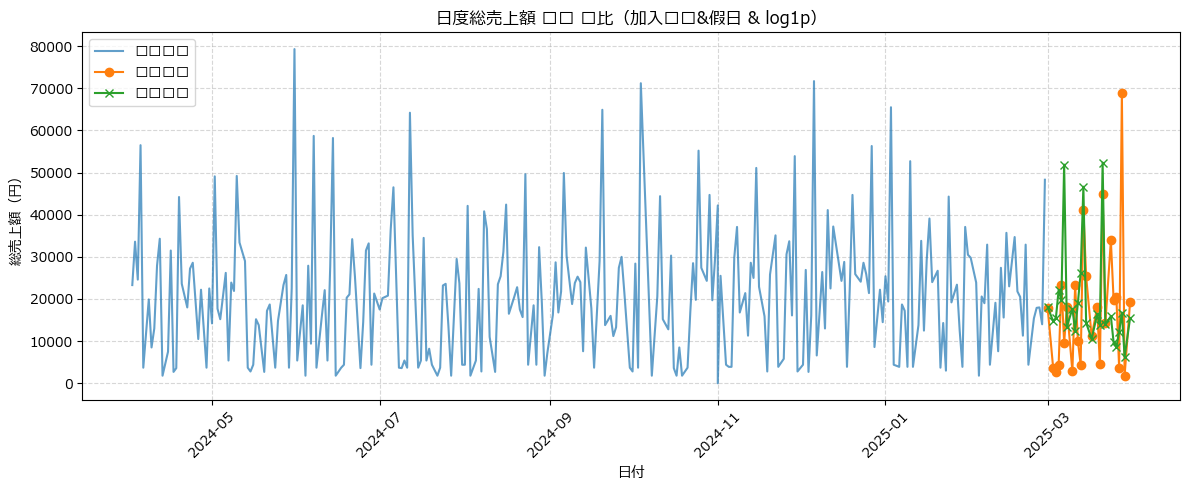

In [104]:
import pandas as pd
import numpy as np
import jpholiday
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# —— 3. 划分训练/测试 —— 
cut_date = df['日付'].max() - pd.Timedelta(days=30)
train = df[df['日付'] < cut_date]
test  = df[df['日付'] >= cut_date]

feature_cols = (
    weather_cols
    + ['weekday','is_weekend','month','dayofyear','is_holiday']
    + ['lag1','roll7_mean']
)

X_train, y_train = train[feature_cols], train['総売上額']
X_test,  y_test  = test[feature_cols],  test['総売上額']

# 对目标做 log1p
y_train_log = np.log1p(y_train)

# —— 4. 训练 XGBoost —— 
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train_log)

# —— 5. 预测 & 评估 —— 
y_pred_log = model.predict(X_test)
y_pred     = np.expm1(y_pred_log)

print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred):.0f} 円")

# —— 6. 可视化对比 —— 
plt.figure(figsize=(12,5))
plt.plot(train['日付'], y_train, label='训练实际', alpha=0.7)
plt.plot(test['日付'],  y_test,  label='测试实际',  marker='o')
plt.plot(test['日付'],  y_pred,  label='测试预测',  marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title('日度総売上額 预测 对比（加入预约&假日 & log1p）')
plt.xlabel('日付')
plt.ylabel('総売上額（円）')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
